In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#import libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

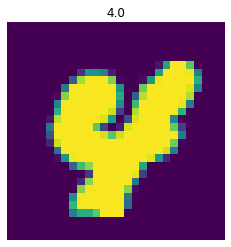

In [10]:
#prepare Dataset
#load data
train = pd.read_csv("train.csv", dtype = np.float32) # kaggle Digit Recognizer

#split data info features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 #normalization

#train test split. Size of train data is %80 and size of test data %20
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

#create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first 
#we create tensor,  then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

#create feature and targets tensor for test set
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

#batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

#pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

#data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

#visualize one of the images in data set
plt.imshow(features_numpy[291].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[291]))
plt.savefig("graph.png")
plt.show()

In [12]:
#create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        #number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        #number of hidden layers
        self.layer_dim = layer_dim
        
        #rnn
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True,
                         nonlinearity ="relu")
        
        #readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        #initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #one time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:,-1, :])
        return out

# create rnn
input_dim = 28 #input dimension
hidden_dim = 100 #hidden layer dimension
layer_dim = 1 #number of hidden layers
output_dim = 10 #output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

#cross entropy loss
error = nn.CrossEntropyLoss()

#SGD optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)     

In [15]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        #clear gradients
        optimizer.zero_grad()
        
        #forward propagation
        outputs = model(train)
        
        #calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        #calculating gradients
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        count +=1
        
        if count % 250 == 0:
            #calculate accuracy
            correct = 0
            total = 0
            #iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(-1,seq_dim,input_dim))
                
                #forward propagation
                outputs = model(test)
                
                #get predictions from the maximum 
                predicted = torch.max(outputs.data, 1)[1]
                
                #total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            #store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            #print loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))     

Iteration: 500  Loss: 0.8653382062911987  Accuracy: 73.45237731933594 %
Iteration: 1000  Loss: 0.6529265642166138  Accuracy: 74.89286041259766 %
Iteration: 1500  Loss: 0.3761917054653168  Accuracy: 89.16666412353516 %
Iteration: 2000  Loss: 0.3226371109485626  Accuracy: 90.72618865966797 %
Iteration: 2500  Loss: 0.17376580834388733  Accuracy: 91.60713958740234 %
Iteration: 3000  Loss: 0.1250847727060318  Accuracy: 94.28571319580078 %
Iteration: 3500  Loss: 0.3748624324798584  Accuracy: 94.85713958740234 %
Iteration: 4000  Loss: 0.044670961797237396  Accuracy: 94.77381134033203 %
Iteration: 4500  Loss: 0.19828416407108307  Accuracy: 95.76190185546875 %
Iteration: 5000  Loss: 0.0685657188296318  Accuracy: 95.9047622680664 %
Iteration: 5500  Loss: 0.1445707380771637  Accuracy: 95.38095092773438 %
Iteration: 6000  Loss: 0.14103400707244873  Accuracy: 96.58333587646484 %
Iteration: 6500  Loss: 0.16348718106746674  Accuracy: 96.36904907226562 %
Iteration: 7000  Loss: 0.13218829035758972  Acc

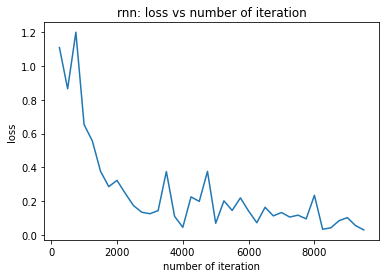

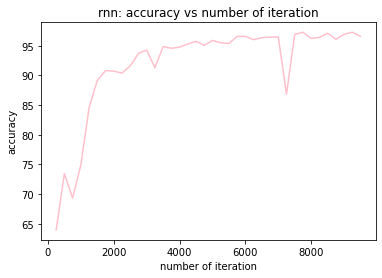

In [16]:
#visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("number of iteration")
plt.ylabel("loss")
plt.title("rnn: loss vs number of iteration")
plt.show()

#visualization accuracy
plt.plot(iteration_list,accuracy_list, color = "pink")
plt.xlabel("number of iteration")
plt.ylabel("accuracy")
plt.title("rnn: accuracy vs number of iteration")
plt.savefig("graph1.png")
plt.show()